# Task
This notebook contains code for:
- Preparation
    - Prepare working environment
    - Importing library
    - Prepare Data
        -Clean missing data 
        - Define and clean outliners
- Data Exploratory
    - Model Clustering
    - Customer Segment
    - Product segment

# Analysis preparation
## Prepare working directory

In [32]:
import os
# Check current working directory.
print(os.getcwd())

#Change the working directory
path = r'C:\Users\Hien dep trai\Desktop\Google Analystics\Capstone'
os.chdir( path )

# Check current working directory and the files in it.
print(os.getcwd())
print(os.listdir(os.getcwd()))

C:\Users\Hien dep trai\Desktop\Google Analystics\Capstone
C:\Users\Hien dep trai\Desktop\Google Analystics\Capstone
['marketing.csv']


## Importing libraries

In [59]:
import numpy as np
import pandas as pd
import datetime
from datetime import date
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.filterwarnings('ignore')

# Load data from cvs.file
data = pd.read_csv('marketing.csv',header=0, sep = '\t')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


## Data Preparation
Create some new features in the dataset to define the customer personalities

In [60]:
#Spending variable creation
data['Age']= 2014 - data['Year_Birth']
data['Spending']=data['MntWines']+data['MntFruits']+data['MntMeatProducts']+data['MntFishProducts']+data['MntSweetProducts']+data['MntGoldProds']

#Seniority variable creation
last_date = date(2014, 10, 4)
data['Seniority']=pd.to_datetime(data['Dt_Customer'], dayfirst=True)
data['Seniority'] = pd.to_numeric(data['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')/30

#Group Marital variable 
data['Marital_Status']=data['Marital_Status'].replace({'Divorced':'Alone','Single':'Alone','Married':'In couple','Together':'In couple','Absurd':'Alone','Widow':'Alone','YOLO':'Alone'})
#Edit and Group Education variable
data['Education']=data['Education'].replace({'Basic':'Undergraduate','2n Cycle':'Undergraduate','Graduation':'Postgraduate','Master':'Postgraduate','PhD':'Postgraduate'})

#Children variable creation
data['Children']=data['Kidhome']+data['Teenhome']
data['Has_child'] = np.where(data.Children> 0, 'Has child', 'No child')
data['Children'].replace({3: "3 children",2:'2 children',1:'1 child',0:"No child"},inplace=True)

#Revise column names
data=data.rename(columns={'MntWines': "Wines",'MntFruits':'Fruits','MntMeatProducts':'Meat','MntFishProducts':'Fish','MntSweetProducts':'Sweets','MntGoldProds':'Gold'})

#Update table
data=data[['Age','Education','Marital_Status','Income','Spending','Seniority','Has_child','Children','Wines','Fruits','Meat','Fish','Sweets','Gold']]

data.head()


,Age,Education,Marital_Status,Income,Spending,Seniority,Has_child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold
0,57,Postgraduate,Alone,58138,1617,25,No child,No child,635,88,546,172,88,88
1,60,Postgraduate,Alone,46344,27,7,Has child,2 children,11,1,6,2,1,6
2,49,Postgraduate,In couple,71613,776,14,No child,No child,426,49,127,111,21,42
3,30,Postgraduate,In couple,26646,53,8,Has child,1 child,11,4,20,10,3,5
4,33,Postgraduate,In couple,58293,422,9,Has child,1 child,173,43,118,46,27,15


## Data cleaning
The last step of data preparation is to handle the outliers and the missing values in the dataset if any.

### Missing values
First I will count the number of missing values:

In [62]:
data.isnull().sum()

Age                0
Education          0
Marital_Status     0
Income            24
Spending           0
Seniority          0
Has_child          0
Children           0
Wines              0
Fruits             0
Meat               0
Fish               0
Sweets             0
Gold               0
dtype: int64

There are 24 Null values in only 1 column so we could delete these values without affects the valuable insights.
The code below will delete null value

In [64]:
data=data.dropna(subset=['Income'])

### Outliners
Finally I'll detect and Remove the Outliers in the data set

I'll use Box plot to find the outliners as if there is an outlier it will plotted as point in boxplot but other population will be grouped together and display as boxes.

Text(0.5, 1.0, 'Seniority Distribution')

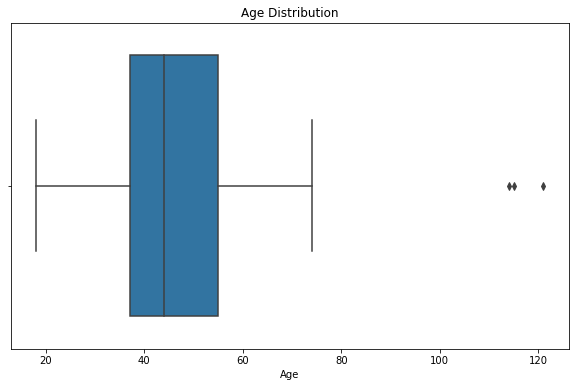

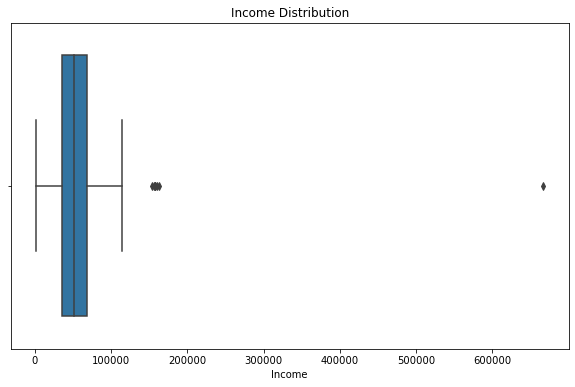

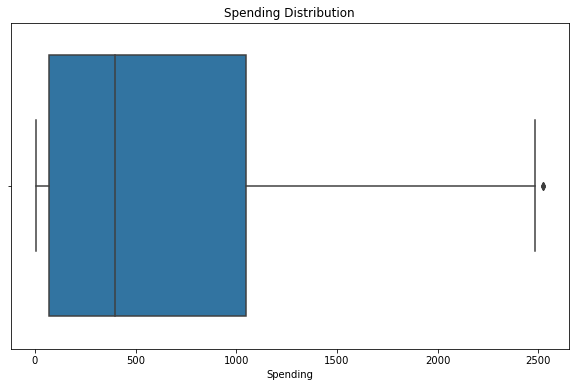

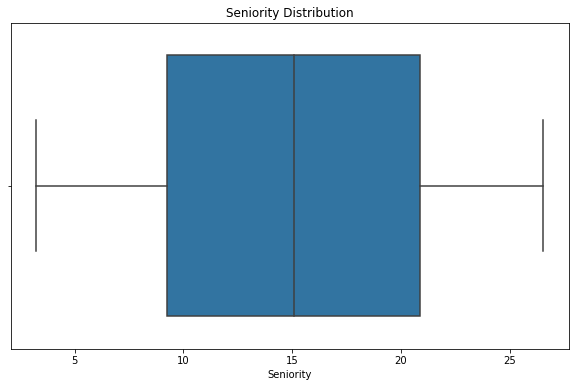

In [69]:
# Creating Box Plot for Age
plt.figure(figsize=(10,6))
sns.boxplot(data['Age'],orient='v')
plt.title('Age Distribution')

# Creating Box Plot for Income
plt.figure(figsize=(10,6))
sns.boxplot(data['Income'],orient='v')
plt.title('Income Distribution')

# Creating Box Plot for Spending
plt.figure(figsize=(10,6))
sns.boxplot(data['Spending'],orient='v')
plt.title('Spending Distribution')

# Creating Box Plot for Seniority
plt.figure(figsize=(10,6))
sns.boxplot(data['Seniority'],orient='v')
plt.title('Seniority Distribution')

The plots shows :
- Age: Above 100 are outliers
- Income: 100k-200k and > 600k. I'll remove only the >600k because some of the customers earn 100k-200k
- Spending: > 2500. I will not remove this as there were actual spending more than 2500 

In [71]:
# delete outliners
data=data[data['Income']<600000]

# Data Exploratory

## Modeling clusters
### Customer segments

The next step is to look at the clustering of clients in the dataset by defining the segments of the clients. 

I define 4 customer segments with 3 metrics:
- Income: above-average vs below-average
- Spending: high vs low
- Seniority: New vs Old

There are 4 customer segments as below:
- Stars: Old customers with above-average income and high spending nature.
- Neet Attention: New customers with below-average income and low spending nature. 
- High Potential: New customers with above-average income and high spending nature.
- Leaky Bucket: Old customers with below-average income and a low spending nature.

First I'll normalize the data and then create customer clustering using the metrics above.

In [75]:
# Normalize data
scaler=StandardScaler()
dataset_temp=data[['Income','Seniority','Spending']]
X_std=scaler.fit_transform(dataset_temp)
X = normalize(X_std,norm='l2')

#Create customer clustering
gmm=GaussianMixture(n_components=4, covariance_type='spherical',max_iter=2000, random_state=5).fit(X)
labels = gmm.predict(X)
dataset_temp['Cluster'] = labels
dataset_temp=dataset_temp.replace({0:'Stars',1:'Need attention',2:'High potential',3:'Leaky bucket'})
data_cld = data.merge(dataset_temp.Cluster, left_index=True, right_index=True)

pd.options.display.float_format = "{:.0f}".format
summary=data_cld[['Income','Spending','Seniority','Cluster']]
summary.set_index("Cluster", inplace = True)
summary=summary.groupby('Cluster').describe().transpose()

print(summary)

Cluster          High potential  Leaky bucket  Need attention  Stars
Income    count             462           585             641    527
          mean            73438         34790           37705  69571
          std             13753         12090           12397  11998
          min             49090          2447            1730  44802
          25%             65298         26490           28839  60895
          50%             71608         35196           38285  68657
          75%             79708         43456           46891  77926
          max            162397         65316           64587 160803
Spending  count             462           585             641    527
          mean             1073           191             122   1252
          std               469           189             128    438
          min                 6             5               6    401
          25%               750            48              39    912
          50%              1033   

Now we have detail income and spending data of each customer segments:
- Stars: Old customers (21 months) with about 69.5k income and 1.2k spending on avarage.
- Need Attention: New customers (9 months) with around 37k income and 122 spending on avarage.
- High Potential: New customers with 73k income and 1k spending on avarage.
- Leaky Bucket: Old customers with 34k income and 191 spending on avarage.

Next, I'll plot this data to display the clustering of customers:

In [49]:
PLOT = go.Figure()
for C in list(data_cld.Cluster.unique()):
    

    PLOT.add_trace(go.Scatter3d(x = data_cld[data_cld.Cluster == C]['Income'],
                                y = data_cld[data.Cluster == C]['Seniority'],
                                z = data_cld[data.Cluster == C]['Spending'],                        
                                mode = 'markers',marker_size = 6, marker_line_width = 1,
                                name = str(C)))
PLOT.update_traces(hovertemplate='Income: %{x} <br>Seniority: %{y} <br>Spending: %{z}')

    
PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Income', titlefont_color = 'black'),
                                yaxis=dict(title = 'Seniority', titlefont_color = 'black'),
                                zaxis=dict(title = 'Spending', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

### Products segments
Now I will futher determine which customer is the biggest spender of each products

First, I will define three segments of the customers according to the age, income and seniority:
- Age: Under 30, 30 -45, 45- 65, Above 65
- Income: Low income, Low to Medium, Medium to high, High Income
- Seniority: New customers, Discovering customers, Emerging customers, Old customers

In [85]:
#Create Age segment
cut_labels_Age = ['Young', 'Adult', 'Mature', 'Senior']
cut_bins = [0, 30, 45, 65, 120]
data_segments = data_cld
data_segments['Age_group'] = pd.cut(data_segments['Age'], bins=cut_bins, labels=cut_labels_Age)

#Create Income segment
cut_labels_Income = ['Low income', 'Low to medium income', 'Medium to high income', 'High income']
data_segments['Income_group'] = pd.qcut(data_segments['Income'], q=4, labels=cut_labels_Income)

#Create Seniority segment
cut_labels_Seniority = ['New customers', 'Discovering customers', 'Emerging customers', 'Old customers']
data_segments['Seniority_group'] = pd.qcut(data_segments['Seniority'], q=4, labels=cut_labels_Seniority)
data_segments=data_segments.drop(columns=['Age','Income','Seniority'])

data_segments.head()

,Education,Marital_Status,Spending,Has_child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Cluster,Age_group,Income_group,Seniority_group
0,Postgraduate,Alone,1617,No child,No child,635,88,546,172,88,88,Stars,Mature,Medium to high income,Old customers
1,Postgraduate,Alone,27,Has child,2 children,11,1,6,2,1,6,Need attention,Mature,Low to medium income,New customers
2,Postgraduate,In couple,776,No child,No child,426,49,127,111,21,42,High potential,Mature,High income,Discovering customers
3,Postgraduate,In couple,53,Has child,1 child,11,4,20,10,3,5,Need attention,Young,Low income,New customers
4,Postgraduate,In couple,422,Has child,1 child,173,43,118,46,27,15,Need attention,Adult,Medium to high income,New customers


Second, I will define new segments according to the spending of customers on each product which will be based on:
- Non Buyer
- Low Buyer
- Frequent Buyer
- Biggest Buyer

In [86]:
data_final = data_segments
cut_labels = ['Low consumer', 'Frequent consumer', 'Biggest consumer']
data_final['Wines_segment'] = pd.qcut(data_final['Wines'][data_final['Wines']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data_final['Fruits_segment'] = pd.qcut(data_final['Fruits'][data_final['Fruits']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data_final['Meat_segment'] = pd.qcut(data_final['Meat'][data_final['Meat']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data_final['Fish_segment'] = pd.qcut(data_final['Fish'][data_final['Fish']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data_final['Sweets_segment'] = pd.qcut(data_final['Sweets'][data_final['Sweets']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data_final['Gold_segment'] = pd.qcut(data_final['Gold'][data_final['Gold']>0],q=[0, .25, .75, 1], labels=cut_labels).astype("object")
data_final.replace(np.nan, "Non consumer",inplace=True)
data_final.drop(columns=['Spending','Wines','Fruits','Meat','Fish','Sweets','Gold'],inplace=True)
data_final = data_final.astype(object)

data_final.head()

,Education,Marital_Status,Has_child,Children,Cluster,Age_group,Income_group,Seniority_group,Wines_segment,Fruits_segment,Meat_segment,Fish_segment,Sweets_segment,Gold_segment
0,Postgraduate,Alone,No child,No child,Stars,Mature,Medium to high income,Old customers,Biggest consumer,Biggest consumer,Biggest consumer,Biggest consumer,Biggest consumer,Biggest consumer
1,Postgraduate,Alone,Has child,2 children,Need attention,Mature,Low to medium income,New customers,Low consumer,Low consumer,Low consumer,Low consumer,Low consumer,Low consumer
2,Postgraduate,In couple,No child,No child,High potential,Mature,High income,Discovering customers,Frequent consumer,Biggest consumer,Frequent consumer,Biggest consumer,Frequent consumer,Frequent consumer
3,Postgraduate,In couple,Has child,1 child,Need attention,Young,Low income,New customers,Low consumer,Low consumer,Frequent consumer,Frequent consumer,Low consumer,Low consumer
4,Postgraduate,In couple,Has child,1 child,Need attention,Adult,Medium to high income,New customers,Frequent consumer,Frequent consumer,Frequent consumer,Frequent consumer,Frequent consumer,Frequent consumer


## Clusters interpretation
I'll interprete the results by visualizing the customer segment using Tableau